This notebook is to explore datasets. The data can be downloaded at the [kaggle competition](https://www.kaggle.com/competitions/edm-cup-2023/data) website.

To replicate the result: put all data inside a folder. And modify the `DATA_DIR` variable below.

# 1. Set up

In [5]:
from pathlib import Path

import pandas as pd
import polars as pl
import seaborn as sns
from edm2023.dataset import Dataset

In [6]:
DATA_DIR = Path.home() / "data-store" / "edm-cup-2023"

assert DATA_DIR.exists()

In [7]:
id_col = "assignment_log_id"
prob_col = "problem_id"
parent_prob_col = "problem_multipart_id"
score_col = "score"

# 2. Load Raw Data

In [8]:
data = {}

for fpath in DATA_DIR.iterdir():
    if fpath.suffix == ".csv":
        data[fpath.stem] = pd.read_csv(fpath)

avialable datasets

In [9]:
data.keys()

dict_keys(['assignment_details', 'hint_details', 'sequence_relationships', 'explanation_details', 'evaluation_unit_test_scores', 'action_logs', 'assignment_relationships', 'training_unit_test_scores', 'problem_details', 'sequence_details'])

# 3. Explore Data

#### 3.1 Training Lables

This is what to predict in training data

In [11]:
data["training_unit_test_scores"].head()

,assignment_log_id,problem_id,score
0,1CEASUAUQJ,18J6436AS5,1
1,2IMKPEIL2Q,9RMI4CZU9,0
2,2IMKPEIL2Q,8F4U5WWTV,0
3,2IMKPEIL2Q,27D3I359NE,1
4,2IMKPEIL2Q,22DY4PFVMV,1


A user might have multiple `assignment_log_id`s.  `problem_id` is the question to be predicted.

In [12]:
# number of data points
train_labels = data["training_unit_test_scores"]
print(f"for training: ")
print(f"the number of data points = {train_labels.shape[0]}")
print(f"the number of users = {train_labels[id_col].unique().shape[0]}")
print(f"the number of unique questions = {train_labels[prob_col].unique().shape[0]}")

for training: 
the number of data points = 452439
the number of users = 42343
the number of unique questions = 1835


Look into the the number occurance for each `problem_id` in the training data to see if there are question cold start problem.

In [16]:
# assuming a user attempt a question once
num_occurs = train_labels.groupby(prob_col)["assignment_log_id"].count()

In [18]:
num_occurs.head()

problem_id
104GN803C7    309
104VLLW3BE     37
1052VSI90Q    149
1056MOBB1X     75
106UK9X9MA     33
Name: assignment_log_id, dtype: int64

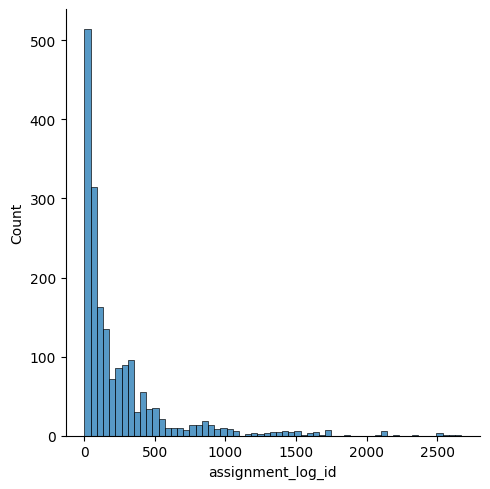

In [20]:
sns.displot(num_occurs)

This is not good, because cold start problem seems to be quite often...

In [21]:
num_occurs.quantile(0.5)

105.0

This seems to mean half the problems have less than 105 occurance in the training data. This poses a challenge to estimate the problem difficulty/discrimination parameter of these problems. 

So if one needs to choose between different types of [IRT](https://www.publichealth.columbia.edu/research/population-health-methods/item-response-theory) models:
1. 2 parameter
2. 3 parameter
3. 4 parameter


According to [this blog](https://www.thetaminusb.com/intro-measurement-r/irt.html#ref-deayala2009theory)

> The popularity of the model is due to its simplicity. It requires smaller sample sizes (100 to 200 people per item may suffice) than the 2PL and 3PL (requiring 500 or more people). The theta scale produced by the Rasch model can also have certain desirable properties, such as consistent score intervals (see de Ayala 2009).

[De Ayala, Rafael Jaime. The theory and practice of item response theory. Guilford Publications, 2013.](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cehs.unl.edu/EdPsych/RJSite/de_Ayala_Appendices_2ndEd.pdf)

2 parameter (Rasch Model) might fit the data better. Also, a hybrid approach might be better: multiple choice questions use a 3 parameter IRT with a guessing parameter and other problems use a 2 parameter IRT

#### 3.2. Problem details

In [22]:
data["problem_details"]["problem_type"].value_counts()

problem_type
Number                          59043
Ungraded Open Response          46984
Multiple Choice                 12834
Algebraic Expression             5210
Exact Match (ignore case)        3911
Check All That Apply             2013
Exact Fraction                   1124
Numeric Expression                872
Exact Match (case sensitive)      438
Ordering                          309
Name: count, dtype: int64

`Multiple Choice`, `Ordering`, `Check All That Apply` can be guessed. And more attempts on those make the next attempt eaiser.

In [24]:
data["problem_details"].head(2)

,problem_id,problem_multipart_id,problem_multipart_position,problem_type,problem_skill_code,problem_skill_description,problem_contains_image,problem_contains_equation,problem_contains_video,problem_text_bert_pca
0,10MFND3HAJ,2MHCTW1IIN,1,Multiple Choice,6.RP.A.3b,Unit Rate,0.0,0.0,1.0,"[0.53955209,-0.96322744,0.49725574,6.28795392,..."
1,IH3MOE7AF,1UEQMXOOFA,1,Multiple Choice,6.RP.A.3b,Unit Rate,0.0,0.0,0.0,"[-1.61147666,-1.50911536,0.52055446,6.01118343..."


In [29]:
print(
    f'There are {data["problem_details"][prob_col].unique().shape[0]} unique problems'
)
print(
    f'There are {data["problem_details"][parent_prob_col].unique().shape[0]} unique parent problems'
)
print(
    f'There are {data["problem_details"]["problem_skill_code"].unique().shape[0]} unique skills'
)

There are 132738 unique problems
There are 70108 unique parent problems
There are 542 unique skills


#### 3.3 Action Logs

In [30]:
data["action_logs"].head(2)

,assignment_log_id,timestamp,problem_id,max_attempts,available_core_tutoring,score_viewable,continuous_score_viewable,action,hint_id,explanation_id
0,2QV1F2GSBZ,1.599151e+09,NaN,NaN,NaN,NaN,NaN,assignment_started,NaN,NaN
1,2QV1F2GSBZ,1.599151e+09,I2GX4OQIE,3.0,answer,1.0,1.0,problem_started,NaN,NaN


#### 3.4 Sequence Rellationships

In [38]:
data["sequence_relationships"].query('unit_test_sequence_id=="MZ52I2Y9"')

,unit_test_sequence_id,in_unit_sequence_id
11468,MZ52I2Y9,2097UZFIHO
11470,MZ52I2Y9,NHRFS57ZS
11472,MZ52I2Y9,5NPJ49S3
11474,MZ52I2Y9,PJM18SCY5
11476,MZ52I2Y9,101F3KRW0W
...,...,...
11616,MZ52I2Y9,1MWX9RYRUS
11618,MZ52I2Y9,28PZDNZZ6Y
11620,MZ52I2Y9,TNIMKBF7Y
11622,MZ52I2Y9,1MU8A5IDXY


This is a many to many relationship. This information is pretty much duplicated with `assignment_relations`

#### 3.5 Assignment Relationships

Looks like assignment log id are difference in `unit_test` and `in_unit`

In [9]:
unit_test_log_ids = set(
    data["assignment_relationships"]["unit_test_assignment_log_id"].to_list()
)
in_unit_log_ids = set(
    data["assignment_relationships"]["in_unit_assignment_log_id"].to_list()
)

In [10]:
log_ids_in_train_labels = set(
    data["training_unit_test_scores"]["assignment_log_id"].to_list()
)
log_ids_in_test_labels = set(
    data["evaluation_unit_test_scores"]["assignment_log_id"].to_list()
)

In [11]:
assert len(log_ids_in_train_labels.intersection(unit_test_log_ids)) == len(
    log_ids_in_train_labels
)
assert len(log_ids_in_test_labels.intersection(unit_test_log_ids)) == len(
    log_ids_in_test_labels
)

In [12]:
assert len(log_ids_in_train_labels.intersection(in_unit_log_ids)) == 0
assert len(log_ids_in_test_labels.intersection(in_unit_log_ids)) == 0

Yep, confirmed, the log in ids in `in_unit` and `unit_test` are different

In [13]:
assert (
    len(log_ids_in_train_labels.intersection(log_ids_in_test_labels)) == 0
), "there are over lap of students in train and test"

There are no overlap between log ids between train and test (their might be over lap between students though)

In [14]:
train_students = set(
    data["training_unit_test_scores"]
    .merge(data["assignment_details"], on="assignment_log_id")["student_id"]
    .unique()
)

In [15]:
test_students = set(
    data["evaluation_unit_test_scores"]
    .merge(data["assignment_details"], on="assignment_log_id")["student_id"]
    .unique()
)

In [16]:
assert (
    len(train_students.intersection(test_students)) == 0
), f"There are {len(train_students.intersection(test_students))} students appear in both train and test"

AssertionError: There are 333 students appear in both train and test

Interesting, so there are overlaps in students.

In [18]:
overlapped_students = train_students.intersection(test_students)

In [19]:
data["evaluation_unit_test_scores"].merge(
    data["assignment_details"], on="assignment_log_id"
)["student_id"].apply(lambda x: x in overlapped_students).mean()

0.05484713350206902

Overlapped students account for 5% of test data. Quite a lot.

#### 3.5 Sequence Details

In [20]:
data['sequence_details']["sequence_problem_ids"][0]

'[AQ0ZKSP6D,2KTD380L98,7CPDNFDLD,2F9VV7RVWU,255S379YS1,1V3K62C4RW,2HYOPEL16J,2MDSQTD9DY,259UZMUFWA,14VGE7DE7G,2KN439QI5,1056MOBB1X,244JZLG18N,1FFS6JHA64,2FAS2CKVU7,2LF0H5OGTK,5LX2Y2G7P,1ZWY4P9Y0K,E0KDAIBRT,5XB0GC5DD,1FNQME208B,1A29AU13ET,KZEM0YZZQ,2ANJRBJG9G,CNEI15IJN,2A23SR042X,1I0G3RGBZ6,1XHKSVBQRQ,2I8LW22RPB,2KMXVCW4NF,QU6GFU28K,16CST92ZQW,184U5N7URM,1DNNEYMFP6,12Z3HNBY11,12W67UOG6,1TFT6FEBK7,1HVRWRZDLP,1AVU400RBD,1FC53EZKNG,1A1E1BJ5ND,U20YSTLUF,URY9KWC6M,GU7NVZAH3,TKF2ER6W2,1UAI737YP,1BKZ30JM05,2DLOFIO3VF,2GSAT66UW8,CWFO1VE6V,21WMIS5N5G,1SS875CCR1,2K2UE1HB9Z,UY1YNL3FH,22O2NPH65Y]'

Each sequence have a number of problems associated with it.

In [21]:
data['assignment_details']['assignment_log_id'].is_unique

True

Each assignment log id have one and only one row in the `assignment_details`

In [22]:
num_students = data['assignment_details']["student_id"].unique().shape[0]
num_assignements = data['assignment_details'].shape[0]

In [23]:
num_assignements / num_students

14.31037707311905

on average, a student will have 14 assignments (but not all assignments have logs)